The goal is to implement

- AdaGrad (It should be better than SAGD)
- OSGM-G (It should at least work)

Here only nescessary code for you:

Here we solve quadratic problem and initialize $A, b$ for different $\sigma$, and compute eigenvalues. You can change eta_candidates to achieve better performance

In [25]:
import numpy as np
import matplotlib.pyplot as plt


In [26]:
def generate_synthetic_data(n, sigma):
    C = 0.01 * np.random.randn(n, n) + np.eye(n)
    D = np.diag(np.random.uniform(0, 1, n))
    A = np.dot(C, np.dot(D, C.T)) + sigma * np.eye(n)  # A = CDC^T + sigma*I
    b = np.random.uniform(0, 1, n)
    return A, b

def least_squares_function(x, A, b):
    return 0.5 * np.linalg.norm(np.dot(A, x) - b)**2

def gradient_least_squares(x, A, b):
    return np.dot(A.T, np.dot(A, x) - b)

n = 100
sigmas = [1e-4, 1e-3, 1e-2, 1e-1, 1]

datasets = []
for sigma in sigmas:
    A, b = generate_synthetic_data(n, sigma)
    datasets.append((A, b, sigma))

A, b, sigma = datasets[3]

ATA = np.dot(A.T, A)
L = np.linalg.eigvalsh(ATA).max()
mu = np.linalg.eigvalsh(ATA).min()
kappa = L / mu

x_star = np.linalg.solve(ATA, np.dot(A.T, b))
f_star = least_squares_function(x_star, A, b)

x_init = np.random.randn(n)
x_init = x_init / np.linalg.norm(x_init)
K = 10000

eta_1 = 1/(4*L**2)

eta_candidates_osgm = [1.5, 1.9, eta_1]
A_inv = np.linalg.inv(A)
P_ini = np.linalg.inv(ATA)
P_i = np.zeros((n, n))
print(f"L: {L}, mu: {mu}, kappa: {kappa}, f(x*): {f_star}, eta_1: {eta_1}")

L: 1.367955613089113, mu: 0.010049881025002658, kappa: 136.11659776726077, f(x*): 3.1535393576515343e-29, eta_1: 0.1335967819562868


Then is the similar algorythm to yours that you need to realize. (Additionally, if you know why it's not so fast as it should be, it could help)
The difference is that you should use norm here (paper).

In [27]:
def osgm_r(f, grad_f, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = P_ini
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-R converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

        x_next = x - P @ grad
        grad_next = grad_f(x_next)

        f_gap = f(x) - f_star
        surrogate_grad = - (grad_next.reshape(-1,1) @ grad.reshape(1,-1)) / f_gap

        P = P - eta * surrogate_grad
        x = x_next

        gap_history.append(f(x) - f_star)

    return gap_history

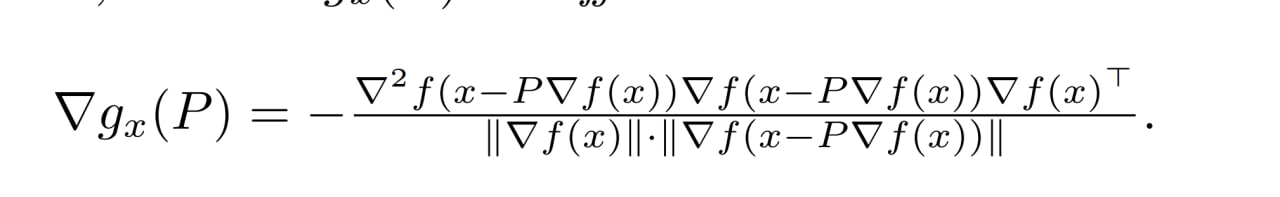

In [28]:

def osgm_g(f, grad_f, hess_f, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init
    P = P_ini
    gap_history = [f(x) - f_star]

    for k in range(num_iterations):
        grad = grad_f(x)
        grad_norm = np.linalg.norm(grad)

        if grad_norm <= tol:
            print(f"OSGM-G converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

        # Gradient step
        x_next = x - P @ grad
        grad_next = grad_f(x_next)
        grad_next_norm = np.linalg.norm(grad_next)

        # Hessian at x_next
        hess = hess_f(x_next)

        # Surrogate gradient based on ∇g_x(P)
        numerator = hess @ grad_next @ grad.T
        denominator = (grad_norm * grad_next_norm) + 1e-12  # avoid divide-by-zero
        surrogate_grad = - numerator / denominator

        # Update
        P = P - eta * surrogate_grad
        x = x_next

        gap_history.append(f(x) - f_star)

    return gap_history


This algorithm you don't need, but you should compare your convergence to it:

In [32]:
def hessian_vector_product(A, v):
    # Efficient computation of Hessian-vector product for least squares:
    # ∇²f(x) · v = Aᵀ (A v)
    return A.T @ (A @ v)

def osgm_g(f, grad_f, A, P_ini, x_init, num_iterations, eta, f_star, tol=1e-10):
    x = x_init            # Initialize current point
    P = P_ini.copy()      # Initialize scaling matrix P
    gap_history = [f(x) - f_star]  # Track function value gap

    for k in range(num_iterations):
        # Compute current gradient ∇f(x)
        grad = grad_f(x)
        grad = np.clip(grad, -1e6, 1e6)  # Clip to prevent explosion
        grad_norm = np.linalg.norm(grad)

        # Check convergence by gradient norm
        if grad_norm <= tol:
            print(f"OSGM-G converged at iteration {k} with gradient norm {grad_norm:.2e}")
            break

        # Compute x⁺ = x - P ∇f(x), i.e., next step
        x_plus = x - P @ grad

        # Compute ∇f(x⁺)
        grad_plus = grad_f(x_plus)
        grad_plus = np.clip(grad_plus, -1e6, 1e6)
        grad_plus_norm = np.linalg.norm(grad_plus)

        # Compute Hessian-vector product: ∇²f(x⁺) ∇f(x⁺)
        hess_vec = hessian_vector_product(A, grad_plus)

        # Construct numerator: outer product of Hessian-vector product and ∇f(x)
        numerator = np.outer(hess_vec, grad)

        # Compute denominator: ||∇f(x)|| * ||∇f(x⁺)||
        denominator = grad_norm * grad_plus_norm

        # Check for numerical issues
        if np.isnan(denominator) or denominator < 1e-12:
            print(f"Skipped surrogate update at iteration {k} due to unstable denominator.")
            x = x_plus  # Still move forward in x
            gap_history.append(f(x) - f_star)
            continue  # Skip this update to P

        # Surrogate gradient of gₓ(P), as in Equation (22)
        surrogate_grad = -numerator / (denominator + 1e-12)

        # Clip surrogate gradient to prevent large updates to P
        surrogate_grad = np.clip(surrogate_grad, -1e3, 1e3)

        # Gradient descent update: P ← P - η ∇gₓ(P)
        P = P - eta * surrogate_grad

        # Optional: Project P to diagonal for stability (recommended in paper)
        P = np.diag(np.diag(P))

        # Optional: Clip P values to prevent runaway growth
        P = np.clip(P, -10, 10)

        # Safety check for NaNs
        if np.any(np.isnan(surrogate_grad)) or np.any(np.isnan(P)):
            print(f"NaN detected at iteration {k}, aborting.")
            break

        # Update x to new position
        x = x_plus

        # Track function value gap
        gap_history.append(f(x) - f_star)

        # Optional: stop if gradient norm explodes (prevent wasted compute)
        if grad_norm > 1e8:
            print(f"Exploding gradient detected at iteration {k}, stopping.")
            break

    else:
        # If loop finishes without converging
        final_grad_norm = np.linalg.norm(grad_f(x))
        print(f"OSGM-G did not converge in {num_iterations} iterations. Final gradient norm: {final_grad_norm:.2e}")

    return gap_history


In [33]:
gap_history_osgm_r_all = []
for eta in eta_candidates_osgm:
  gap_history_osgm_r= osgm_r(
      lambda x: least_squares_function(x, A, b),
      lambda x: gradient_least_squares(x, A, b),
      P_i,
      x_init,
      K,
      eta,
      f_star
  )
  gap_history_osgm_r = [g / gap_history_osgm_r[0] for g in gap_history_osgm_r]
  gap_history_osgm_r_all.append(gap_history_osgm_r)

gap_history_sagd = sagd(
    lambda x: least_squares_function(x, A, b),
    lambda x: gradient_least_squares(x, A, b),
    x_init,
    K,
    L,
    mu,
    f_star
)
gap_history_sagd = [g / gap_history_sagd[0] for g in gap_history_sagd]

OSGM-R converged at iteration 857 with gradient norm 9.70e-11
OSGM-R converged at iteration 763 with gradient norm 9.68e-11
OSGM-R converged at iteration 2845 with gradient norm 9.89e-11
SAGD converged at iteration 272 with gradient norm 9.52e-11


In [34]:
gap_history_osgm_g_all = []

for eta in eta_candidates_osgm:
    gap_history_osgm_g = osgm_g(
        lambda x: least_squares_function(x, A, b),
        lambda x: gradient_least_squares(x, A, b),
        A,
        P_i,
        x_init,
        K,
        eta,
        f_star
    )
    gap_history_osgm_g = [g / gap_history_osgm_g[0] for g in gap_history_osgm_g]
    gap_history_osgm_g_all.append(gap_history_osgm_g)
    
 


Skipped surrogate update at iteration 1310 due to unstable denominator.
Skipped surrogate update at iteration 1311 due to unstable denominator.
Skipped surrogate update at iteration 1312 due to unstable denominator.
Skipped surrogate update at iteration 1313 due to unstable denominator.
Skipped surrogate update at iteration 1314 due to unstable denominator.
Skipped surrogate update at iteration 1315 due to unstable denominator.
Skipped surrogate update at iteration 1316 due to unstable denominator.
Skipped surrogate update at iteration 1317 due to unstable denominator.
Skipped surrogate update at iteration 1318 due to unstable denominator.
Skipped surrogate update at iteration 1319 due to unstable denominator.
Skipped surrogate update at iteration 1320 due to unstable denominator.
Skipped surrogate update at iteration 1321 due to unstable denominator.
Skipped surrogate update at iteration 1322 due to unstable denominator.
Skipped surrogate update at iteration 1323 due to unstable denom

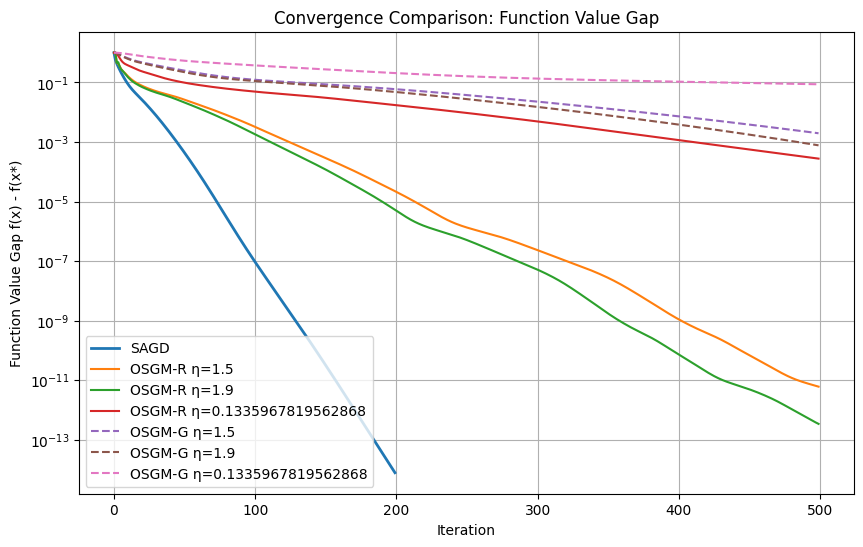

In [35]:
iterations = 500
it = 200

plt.figure(figsize=(10, 6))

# Plot SAGD
plt.plot(range(it), gap_history_sagd[:it], label='SAGD', linewidth=2)

# Plot OSGM-R
for index, eta in enumerate(eta_candidates_osgm):
    it_r = min(iterations, len(gap_history_osgm_r_all[index]))
    if np.any(np.isnan(gap_history_osgm_r_all[index])):
        continue
    plt.plot(range(it_r), gap_history_osgm_r_all[index][:it_r], label=f'OSGM-R η={eta}')

# Plot OSGM-G
for index, eta in enumerate(eta_candidates_osgm):
    it_g = min(iterations, len(gap_history_osgm_g_all[index]))
    if np.any(np.isnan(gap_history_osgm_g_all[index])):
        continue
    plt.plot(range(it_g), gap_history_osgm_g_all[index][:it_g], linestyle='--', label=f'OSGM-G η={eta}')

# Final formatting
plt.title('Convergence Comparison: Function Value Gap')
plt.xlabel('Iteration')
plt.ylabel('Function Value Gap f(x) - f(x*)')



plt.grid(True)
plt.yscale('log')
plt.legend()
plt.show()
